[Adaptado de [TinyML - Machine Learning for Embedding Devices](https://github.com/Mjrovai/UNIFEI-IESTI01-TinyML) de [Marcelo José Rovai](http://lattes.cnpq.br/4234592863079468) do [Instituto de Engenharia de Sistemas e Tecnologias da Informação – IESTI - Campus de Itajubá](https://unifei.edu.br/iesti/)]

# Edge Impulse - Bloco de análise espectral
[![Abra no Colab <](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/fabiobento/continuous-motion-recognition/blob/main/Edge_Impulse_Spectral_Analysis_Block.ipynb)

## FFT
### Características estatísticas(domínio do tempo) por eixo/canal:
Após a filtragem por meio de um filtro Butterworth IIR (se ativado), **a média é subtraída do sinal.** e são calculados:
- RMS
- Skewness
- Curtose

### Características espectrais (domínio de frequência) por eixo/canal:
- Potência espectral
- Skewness
- Curtose


### Potência espectral
O sinal filtrado é passado para a seção de potência espectral(_spectral power_), que calcula a **FFT** para calcular as características espectrais.
- A janela será dividida em quadros (ou “subjanelas”), e a FFT é calculada a partir de cada quadro.
- O comprimento da FFT determina o número de compartimentos(_bins_) da FFT, bem como a resolução dos picos de frequência que você pode separar. 
- O número total de recursos de potência espectral será alterado, dependendo de como você definir os parâmetros de filtro e FFT. Sem filtragem, o número de recursos é 1/2 do comprimento da FFT 

https://docs.edgeimpulse.com/docs/edge-impulse-studio/processing-blocks/spectral-features

## Wavelets
No caso das **Wavelets**, os recursos extraídos são recursos estatísticos, recursos de cruzamento e recursos de entropia (14 por camada): 

- `[11] Recursos`: são calculados **n5, n25, n75, n95, média, mediana, desvio padrão (std), variância (var) e raiz quadrada média (rms), curtose e assimetria (skew)**. 

- `[2] Recursos`: **Taxa de cruzamento zero (zcross) e taxa de cruzamento médio (mcross)** são as vezes em que o sinal passa pela linha de base y = 0 e pelo nível médio y = u por unidade de tempo, respectivamente

- `[1] Recurso`: Os recursos de **Entropia** são uma medida característica da complexidade do sinal

- Todos os 14 valores são calculados para cada camada (incluindo L0, o sinal original)

- `[Inputs]`: O **nível de decomposição de wavelet** (*1, 2, ...*) e o tipo de **Wavelet** (*bior1.3, db2, ...*) a ser usado devem ser definidos. Se, por exemplo, o nível 1 for escolhido, L0 e L1 serão usados para o cálculo do recurso.

- O número total de recursos mudará, dependendo de como você definir o filtro e o número de camadas. Por exemplo, com a filtragem **[None]** e o nível **[1]**, o número de recursos por eixo será 14 x 2 (L0 e L1) = 28. Para 6 eixos, teremos um total de 168 recursos. 

## Características Estatísticas

In [1]:
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns
import math
from scipy.stats import skew, kurtosis
from scipy import signal
from scipy.signal import welch
from scipy.stats import entropy
from sklearn import preprocessing
import pywt

In [2]:
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['lines.linewidth'] = 3

## Funções

In [3]:
def plot_data(sensors, axis, title):
    [plt.plot(x, label=y) for x,y in zip(sensors, axis)]
    plt.legend(loc='lower right')
    plt.title(title)
    plt.xlabel('#Amostra')
    plt.ylabel('Valor')
    plt.box(False)
    plt.grid()
    plt.show()

Vamos obter uma amostra de dados de acelerômetros (janela de 2 segundos; frequência de amostragem de 62,5 Hz)

<figure>
    <center> <img src="https://github.com/fabiobento/continuous-motion-recognition/raw/main/images/features.png"  alt='missing' width="800"  ><center/>
<figure/>

In [4]:
f =  62.5  # Hertz
wind_sec = 2 # seconds
axis = ['accX', 'accY', 'accZ']
n_sensors = len(axis)
print (f'Frequência = {f}Hz')
print (f'Janela = {wind_sec}s')
print (f'Quantidade de sensores = {len(axis)}')

Frequência = 62.5Hz
Janela = 2s
Quantidade de sensores = 3


In [5]:
data=[-5.6330, 0.2376, 9.8701, -5.9442, 0.4830, 9.8701, -5.4217, 0.9433, 9.8521, -4.1474, 0.5261, 9.8246, -0.4896, -0.2592, 9.7217, -1.9465, 0.1472, 9.9108, -4.8261, 0.0449, 9.8964, -5.8861, 0.6291, 9.8988, -3.6248, 0.6734, 9.8731, -3.2585, 0.5866, 9.8491, -3.2304, 0.3358, 9.9000, -2.4187, -0.1071, 9.8593, -1.6017, -0.5381, 9.7941, -2.2577, -0.1760, 9.7803, -1.2438, -0.2873, 9.8438, -0.9978, 0.4076, 9.6696, -1.3210, -1.6514, 9.9754, -2.3337, -0.6740, 9.8084, -2.1272, -0.7195, 9.8330, -0.9792, -0.5584, 9.8013, 0.4615, 0.3041, 9.8306, 0.4076, 0.1861, 9.8390, -0.2682, -0.3226, 9.8043, 1.8477, 0.0377, 9.7977, 0.7560, -0.3166, 9.8072, 0.4764, -0.2215, 9.9084, 1.5724, -0.2274, 9.6744, 3.5195, -1.0169, 9.8234, 5.0560, -0.7021, 9.8270, 1.5137, -2.2853, 9.7875, 2.4044, 0.3328, 9.7582, 6.3111, -1.8765, 9.8288, 1.7196, -0.7302, 9.8623, 2.9999, -0.3268, 9.6516, 2.0800, -1.0092, 10.0347, 0.2867, -0.2406, 9.9653, 4.7908, -2.2739, 9.5343, -0.2652, 2.5833, 11.1749, 5.4857, -1.2103, 9.5672, 3.6763, -2.2194, 9.7282, 2.3888, -1.7867, 9.8276, 2.8802, -1.1588, 9.8970, 2.3320, -1.4042, 9.7977, 2.0650, -0.6913, 9.8228, 2.4505, -0.6297, 9.8025, 1.2851, -0.4441, 9.8354, 1.5113, -0.2927, 9.8282, 1.5616, 0.2173, 9.8090, 1.0199, 0.9936, 9.9192, 1.0570, 0.2257, 9.9317, 0.5112, 0.0192, 9.8336, -0.2867, -0.6770, 9.8180, -0.2017, -1.1558, 9.8192, -0.3322, -0.9535, 9.7665, -0.9379, -0.4998, 9.7588, -1.2540, -0.3106, 9.8240, -1.5287, 0.0634, 9.9108, -2.6606, 0.5758, 9.8779, -3.2723, 0.6482, 9.8761, -4.0121, 0.3585, 9.8462, -4.4945, 1.2276, 9.9042, -4.5849, 1.7909, 9.9000, -4.4335, 1.6777, 9.9060, -5.1697, 1.1486, 9.9377, -3.9115, 0.7159, 9.8857, -1.8699, -0.5561, 9.8845, -1.1618, 0.1490, 9.8497, -3.2902, 0.6542, 9.8683, -5.5055, 0.7530, 9.8845, -5.1739, 0.7482, 9.8821, -3.6524, 0.5028, 9.8641, -3.2645, 0.1778, 9.8629, -3.2423, -0.0048, 9.8970, -1.6729, 0.0311, 9.8013, -0.3244, -0.3364, 9.7839, -0.9966, -0.6692, 9.8761, -1.9950, -0.2113, 9.8964, -2.0075, 0.3011, 9.7965, -1.8633, 0.3370, 9.9288, -0.8739, 0.5926, 9.8162, -0.4046, 0.3974, 9.8665, 0.4830, -0.6788, 9.8659, 0.6201, -0.8948, 9.8312, 0.8027, -0.8200, 9.7725, 0.5213, -0.6087, 9.8126, 0.0275, -0.5608, 9.7713, 0.2412, -0.1885, 9.8665, 0.7596, -0.0581, 9.8521, 0.6907, -0.5483, 9.8881, 0.3244, -0.9978, 9.7773, 1.0576, -0.6584, 9.7887, 2.0722, -0.2753, 9.8120, 1.4647, -0.2221, 9.8928, 1.4617, 0.1341, 9.8120, 2.2188, -0.0329, 9.7773, 3.6859, -0.5171, 9.9084, 1.9172, -0.9744, 9.8019, 1.7095, -0.6734, 9.8061, 3.4327, -1.1205, 9.8372, 3.4399, -0.9679, 9.8342, 2.4307, -1.3473, 9.8240, 1.1283, -0.1945, 9.9479, 6.9707, -0.0946, 9.6744, 3.0957, -1.3120, 9.8617, 3.1448, -1.0924, 9.7701, 2.9862, -1.1349, 9.8144, 2.6073, -0.7344, 9.8025, 2.0824, -0.6955, 9.8396, 1.9932, -0.6812, 9.7809, 1.6640, -0.3089, 9.8845, 2.6833, -0.2879, 9.7929, 2.3272, -0.1706, 9.8288, 1.3761, -0.3537, 9.9228, 0.9643, -1.0145, 9.8318, 1.3420, -1.1498, 9.8360, 0.9942, -0.7326, 9.8288, 0.1395, -0.3202, 9.8695, -0.2993, -0.3220, 9.8527, -0.6967, -0.3980, 9.8360, -1.4706, -0.1879, 9.8342, -1.9974, 0.5267, 9.8474, -2.1883, 0.5584, 9.8695, -2.3409, 0.4447, 9.8815, -3.1214, 0.1730, 9.9168, -3.1502, -0.0156, 9.9174]
No_raw_features = len(data)
N = int(No_raw_features/n_sensors)
print (f"Quantidade de características brutas: {No_raw_features};\nN= {N} (quantidade de características por eixo)")

Quantidade de características brutas: 375;
N= 125 (quantidade de características por eixo)


In [6]:
# Características Processadas
features = [2.7322, -0.0978, -0.3813, 2.3980, 3.8924, 24.6841, 9.6303, 8.4867, 7.7793, 2.9963, 5.6242, 3.4198, 4.2735, 0.7833, 0.1735, 1.1696, 0.9426, -0.8039, 5.4290, 0.9990, 1.0315, 0.9459, 1.8117, 0.9088, 1.3302, 3.1120, 0.1383, 6.8629, 65.3726, 0.3117, -1.3812, 0.0606, 0.0570, 0.0567, 0.0976, 0.1940, 0.2574, 0.2083, 0.1660]
N_feat = len(features)
N_feat_axis = int(N_feat/n_sensors)

In [7]:
print(f' - Número total de recursos sem filtragem: {N_feat}')
print(f' - Número total de recursos estatísticos : {3*n_sensors}')
print(f' - Número total de recursos espectrais : {N_feat-3*n_sensors}')
print(f' - Total Número de recursos por eixo: {N_feat_axis}')

 - Número total de recursos sem filtragem: 39
 - Número total de recursos estatísticos : 9
 - Número total de recursos espectrais : 30
 - Total Número de recursos por eixo: 13


- 3 Recursos estatísticos (tempo) por eixo --> Total: 9 recursos 
- 8 Recursos de potência espectral (Freq) por eixo --> Total: 24 recursos
- 2 Skew/Kurtosis espectral (freq) por eixo -> Total: 6 recursos
- Total de recursos processados = 9+24+6 = 39

Recursos por eixo: `[rms] [skew] [kurtosis] [spectral skew] [spectral kurtosis] [Spectral Power 1] ... [Spectral Power 8]`

### Dividir dados brutos (_raw data_) por sensor

In [14]:
accX = data[0::3]
accY = data[1::3]
accZ = data[2::3]
sensors = [accX, accY, accZ]

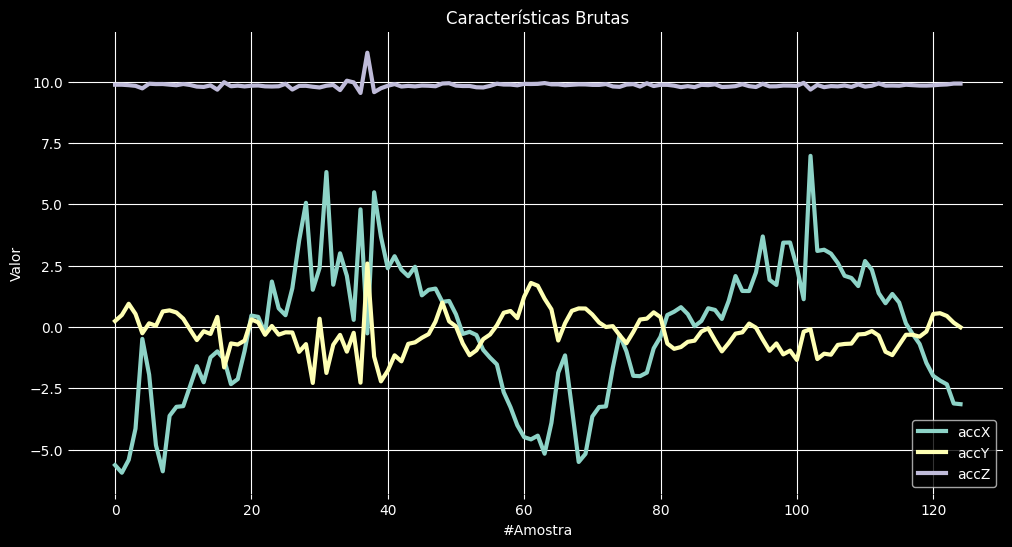

In [15]:

plot_data(sensors, axis, 'Características Brutas')

### Subtraindo a média dos dados
Subtrair a média de um conjunto de dados é uma etapa comum de pré-processamento de dados em estatística e aprendizado de máquina. O objetivo de subtrair a média dos dados é centralizar os dados em torno de zero. Isso é importante porque pode revelar padrões e relacionamentos que podem estar ocultos se os dados não estiverem centralizados.

Aqui estão alguns motivos específicos pelos quais a subtração da média pode ser útil:

- Simplifica a análise: Ao centralizar os dados, a média se torna zero, o que pode tornar alguns cálculos mais simples e fáceis de interpretar.
- Remove a tendência: se os dados tiverem uma tendência, a subtração da média pode remover essa tendência e permitir uma análise mais precisa.
- Pode revelar padrões: A centralização dos dados pode ajudar a revelar padrões que podem estar ocultos se os dados não estiverem centralizados. Por exemplo, se estiver analisando um conjunto de dados de série temporal, a centralização dos dados pode ajudá-lo a identificar tendências ao longo do tempo.
- Pode melhorar o desempenho: Em alguns algoritmos de aprendizado de máquina, a centralização dos dados pode melhorar o desempenho, reduzindo a influência de outliers e tornando os dados mais facilmente comparáveis.
De modo geral, a subtração da média é uma técnica simples, mas poderosa, que pode ser usada para melhorar a análise e a interpretação dos dados.

In [16]:
dtmean = [(sum(x)/len(x)) for x in sensors]
[print(x+' médio'+'= ', round(y, 4)) for x,y in zip(axis, dtmean)][0]

accX médio=  -0.1646
accY médio=  -0.2438
accZ médio=  9.8472


In [17]:
accX = [(x - dtmean[0]) for x in accX]
accY = [(x - dtmean[1]) for x in accY]
accZ = [(x - dtmean[2]) for x in accZ]
sensors = [accX, accY, accZ]

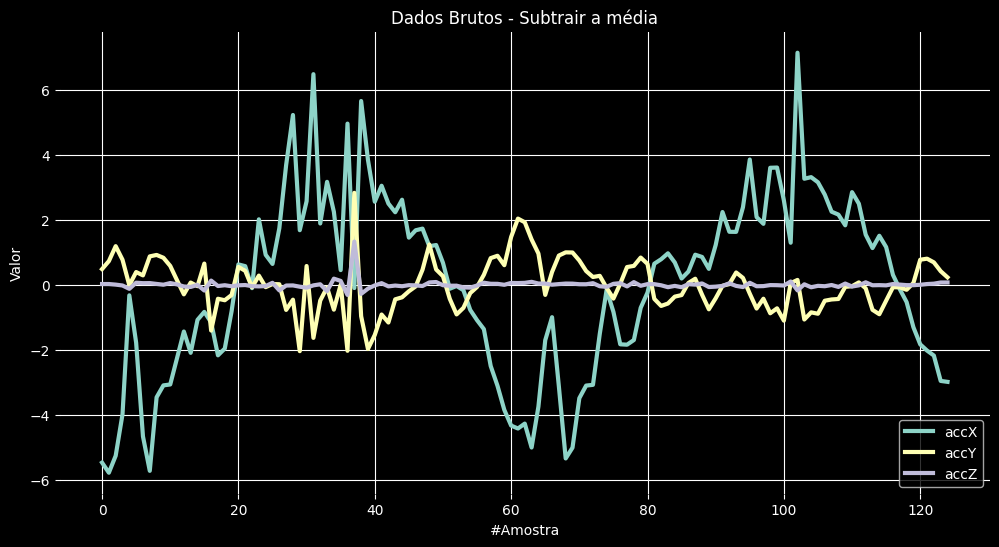

In [18]:
plot_data(sensors, axis, 'Dados Brutos - Subtrair a média')

### Cálculo do valor RMS

O valor RMS de um conjunto de valores (ou uma forma de onda de tempo contínuo) é a raiz quadrada da média aritmética dos quadrados dos valores ou o quadrado da função que define a forma de onda contínua.

Na física, o valor de corrente RMS também pode ser definido como o “valor da corrente direta que dissipa a mesma potência em um resistor”.

In the case of a set of n values $\{x_{1},x_{2},\dots ,x_{n}\}$, the RMS is:

$\displaystyle x_{\text{RMS}}={\sqrt {{\frac {1}{n}}\left(x_{1}^{2}+x_{2}^{2}+\cdots +x_{n}^{2}\right)}}.$

`OBSERVE que o valor RMS é diferente para os dados brutos originais e após a subtração da média`

In [ ]:
# Using numpy and standartized data (subtracting mean)
rms = [np.sqrt(np.mean(np.square(x))) for x in sensors]
[print('rms_'+x+'= ', round(y, 4)) for x,y in zip(axis, rms)][0]

In [ ]:
# Compare with Edge Impulse result features
features[0:N_feat:N_feat_axis]

### Skewness and kurtosis calculation

In statistics, skewness and kurtosis are two ways to measure the **shape of a distribution**.

[**Skewness**](https://en.wikipedia.org/wiki/Skewness) is a measure of the asymmetry of a distribution. This value can be positive or negative.
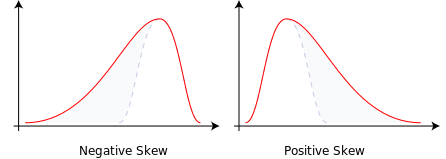
- A negative skew indicates that the tail is on the left side of the distribution, which extends towards more negative values.
- A positive skew indicates that the tail is on the right side of the distribution, which extends towards more positive values.
- A value of zero indicates that there is no skewness in the distribution at all, meaning the distribution is perfectly symmetrical.

[**Kurtosis**](https://en.wikipedia.org/wiki/Kurtosis) is a measure of whether or not a distribution is heavy-tailed or light-tailed relative to a normal distribution.

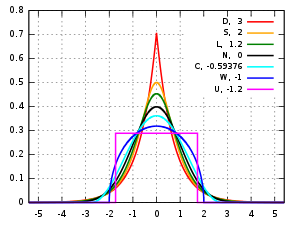
- The kurtosis of a normal distribution is 0.
- If a given distribution has a kurtosis is negative, it is said to be playkurtic, which means it tends to produce fewer and less extreme outliers than the normal distribution.
- If a given distribution has a kurtosis positive, it is said to be leptokurtic, which means it tends to produce more outliers than the normal distribution.

`NOTE that the Skewness and Kurtosis values are the same for original raw data and after subtracting the mean`

Let's see the data distribution and the Skewness and kurtosis calculation

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(10, 3))
sns.kdeplot(accX, fill=True, ax=axes[0])
sns.kdeplot(accY, fill=True, ax=axes[1])
sns.kdeplot(accZ, fill=True, ax=axes[2])
axes[0].set_title('accX')
axes[1].set_title('accY')
axes[2].set_title('accZ')
plt.suptitle('IMU Sensors distribution', fontsize=16, y=1.02)
plt.show()

In [ ]:
skew_list = [skew(x, bias=False) for x in sensors]
[print('skew_'+x+'= ', round(y, 4)) for x,y in zip(axis, skew_list)][0]

In [ ]:
# Compare with Edge Impulse result features
features[1:N_feat:N_feat_axis]

In [ ]:
kurt = [kurtosis(x, bias=False) for x in sensors]
[print('kurt_'+x+'= ', round(y, 4)) for x,y in zip(axis, kurt)][0]

In [ ]:
# Compare with Edge Impulse result features
features[2:N_feat:N_feat_axis]

## Spectral features

In [ ]:
FFT_Lenght = 16 
fs = f 
print (f"Sample Frequency: {f}Hz")

Once the sampled window usually is larger than the FFT size, the window will be broken into frames (or "sub-windows"), and the FFT is calculated from each frame.

**FFT length** - The FFT size. This determines the number of FFT bins as well as the resolution of frequency peaks that you can separate. A lower number means more signals will average together in the same FFT bin, but also reduces the number of features and model size. A higher number will separate more signals into separate bins, but generates a larger model.

### Spectral Power - Welch’s method 
https://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.signal.welch.html

To split the signal on frequency domain in bins and calculate the power spectrum for each bin, we should use a method called **Welch’s method**. 

This method divides the signal into overlapping segments, applies a window function to each segment, computes the periodogram of each segment using DFT, and averages them to obtain a smoother estimate of the power spectrum. 

In [ ]:
# Function used by Edge Impulse insteady scipy.signal.welch().
def welch_max_hold(fx, sampling_freq, nfft, n_overlap):
    n_overlap = int(n_overlap)
    spec_powers = [0 for _ in range(nfft//2+1)]
    ix = 0
    while ix <= len(fx):
        # Slicing truncates if end_idx > len, and rfft will auto zero pad
        fft_out = np.abs(np.fft.rfft(fx[ix:ix+nfft], nfft))
        spec_powers = np.maximum(spec_powers, fft_out**2/nfft)
        ix = ix + (nfft-n_overlap)
    return np.fft.rfftfreq(nfft, 1/sampling_freq), spec_powers

In [ ]:
fax,Pax = welch_max_hold(accX, fs, FFT_Lenght, 0)
fay,Pay = welch_max_hold(accY, fs, FFT_Lenght, 0)
faz,Paz = welch_max_hold(accZ, fs, FFT_Lenght, 0)

In [ ]:
specs = [Pax, Pay, Paz ]

Note that since we subtract the mean at the begining, bin 0 (DC) will always be ~0, so we skip it (p[1:])



In [ ]:
# Plot power spectrum versus frequency 
# Since we subtract the mean at the begining, bin 0 (DC) will always be ~0, so skip it
plt.plot(fax,Pax, label='accX')
plt.plot(fay,Pay, label='accY')
plt.plot(faz,Paz, label='accZ')

plt.legend(loc='upper right')
plt.xlabel('Frequency (Hz)')
#plt.ylabel('PSD [V**2/Hz]')
plt.ylabel('Power')
plt.title('Power spectrum P(f) using Welch\'s method')
plt.grid()
plt.box(False)
plt.show()

In [ ]:
print("\nCalculated Spectral Power features for accX:")
[print(round(x, 4)) for x in Pax[1:]][0]

In [ ]:
print("\nCalculated Spectral Power features for accY:")
[print(round(x, 4)) for x in Pay[1:]][0]

In [ ]:
print("\nCalculated Spextral Power features for accZ:")
[print(round(x, 4)) for x in Paz[1:]][0]

### Spectral Skewness and Kurtosis

In [ ]:
spec_skew = [skew(x, bias=False) for x in specs]
[print('spectral_skew_'+x+'= ', round(y, 4)) for x,y in zip(axis, spec_skew)][0]

In [ ]:
spec_kurtosis = [kurtosis(x, bias=False) for x in specs]
[print('spectral_kurtosis_'+x+'= ', round(y, 4)) for x,y in zip(axis, spec_kurtosis)][0]

### List Spectral features per axis and compare with EI

In [ ]:
print("EI Processed Spectral features (accX): ")
print(features[3:N_feat_axis][0:])
print("\nCalculated features:")
print (round(spec_skew[0],4))
print (round(spec_kurtosis[0],4))
[print(round(x, 4)) for x in Pax[1:]][0]

In [ ]:
print("EI Processed Spectral features (accY): ")
print(features[16:26][0:]) #13: 3+N_feat_axis;  26 = 2x N_feat_axis
print("\nCalculated features:")
print (round(spec_skew[1],4))
print (round(spec_kurtosis[1],4))
[print(round(x, 4)) for x in Pay[1:]][0]

In [ ]:
print("EI Processed Spectral features (accZ): ")
print(features[29:][0:]) #29: 3+(2*N_feat_axis); 
print("\nCalculated features:")
print (round(spec_skew[2],4))
print (round(spec_kurtosis[2],4))
[print(round(x, 4)) for x in Paz[1:]][0]

# Wavelets

<figure>
    <center> <img src="https://github.com/fabiobento/continuous-motion-recognition/raw/main/images/wavelets-features.png"  alt='missing' width="800"  ><center/>
<figure/>

In [ ]:
wavelet_name='bior1.3'
num_layer = 1

In [ ]:
wavelet = pywt.Wavelet(wavelet_name)
[phi_d,psi_d,phi_r,psi_r,x] = wavelet.wavefun(level=5)
plt.plot(x, psi_d, color='red')
plt.title('Wavelet Function')
plt.ylabel('Value')
plt.xlabel('Time')
plt.grid()
plt.box(False)
plt.show()

In [ ]:
# Processed Features

features = [3.6251, 0.0615, 0.0615, -7.3517, -2.7641, 2.8462, 5.0924, 0.4063, -0.2133, 3.8473, 15.0327, 3.8532, -0.2905, -0.7966, 3.3929, 0.5231, 0.5538, -1.3234, -0.2743, 0.5206, 1.4599, 0.1350, 0.1264, 0.9544, 0.9250, 0.9627, 0.6358, 3.0473, 3.6597, 0.3077, 0.3077, -1.3234, -0.6492, 0.7844, 1.3610, 0.0659, 0.0276, 0.9345, 0.8868, 0.9349, 0.2807, -0.0589, 3.1609, 0.5385, 0.5385, -0.5356, -0.2709, 0.2298, 0.8409, -0.0830, -0.0377, 0.6040, 0.3706, 0.6052, -2.2028, 13.7548, 3.1061, 0.4000, 0.3692, -0.1126, -0.0494, 0.0347, 0.1022, -0.0137, 0.0025, 0.1053, 0.0113, 0.1053, 4.3072, 26.4113, 2.6219, 0.4462, 0.3385, -0.1122, -0.0250, 0.0233, 0.0793, 0.0008, -0.0183, 0.1529, 0.0237, 0.1540, -6.3676, 44.9559]
N_feat = len(features)
N_feat_axis = int(N_feat/n_sensors)

In [ ]:
print(f' - Total Number of features without filtering: {N_feat}')
print(f' - Total Number of features per layer: {int(N_feat/(num_layer+1))}')
print(f' - Total Number of features per axis per layer: {N_feat_axis}')

In [ ]:
(accX_l1, accX_f) = pywt.dwt(accX, wavelet_name)
(accY_l1, accY_f) = pywt.dwt(accY, wavelet_name)
(accZ_l1, accZ_f) = pywt.dwt(accZ, wavelet_name)
sensors_l1 = [accX_l1, accY_l1, accZ_l1]

In [ ]:
# Plot power spectrum versus frequency 
# Since we subtract the mean at the begining, bin 0 (DC) will always be ~0, so skip it
plt.plot(accX_l1, label='accX')
plt.plot(accY_l1, label='accY')
plt.plot(accZ_l1, label='accZ')
plt.legend(loc='lower right')
plt.xlabel('Time')
plt.ylabel('Value')
plt.title('Wavelet Approximation')
plt.grid()
plt.box(False)
plt.show()

##  Feature Extraction Functions

In [ ]:
def calculate_statistics(signal):
    n5 = np.percentile(signal, 5)
    n25 = np.percentile(signal, 25)
    n75 = np.percentile(signal, 75)
    n95 = np.percentile(signal, 95)
    median = np.percentile(signal, 50)
    mean = np.mean(signal)
    std = np.std(signal)
    var = np.var(signal)
    rms = np.sqrt(np.mean(np.square(signal)))
    return [n5, n25, n75, n95, median, mean, std, var, rms]

In [ ]:
stat_feat_l0 = [calculate_statistics(x) for x in sensors]
stat_feat_l1 = [calculate_statistics(x) for x in sensors_l1]

In [ ]:
print (f"feat_l0 or l_1 has {len(stat_feat_l0[0])} statistical features for each of the {len(stat_feat_l0)} axis")

In [ ]:
skew_l0 = [skew(x, bias=False) for x in sensors]
skew_l1 = [skew(x, bias=False) for x in sensors_l1]
kurtosis_l0 = [kurtosis(x, bias=False) for x in sensors]
kurtosis_l1 = [kurtosis(x, bias=False) for x in sensors_l1]

In [ ]:
def getZeroCrossingRate(arr):
    my_array = np.array(arr)
    zcross = float("{0:.2f}".format((((my_array[:-1] * my_array[1:]) < 0).sum())/len(arr))) 
    return zcross

def getMeanCrossingRate(arr):
    mcross = getZeroCrossingRate(np.array(arr) - np.mean(arr))
    return mcross

In [ ]:
def calculate_crossings(list):
    zcross=[]
    mcross=[]
    for i in range(len(list)):
        zcross_i = getZeroCrossingRate(list[i])
        zcross.append(zcross_i)
        mcross_i = getMeanCrossingRate(list[i])
        mcross.append(mcross_i)
    return zcross, mcross   

In [ ]:
calculate_crossings(sensors_l1)

In [ ]:
cross_l0 = calculate_crossings(sensors)
cross_l1 = calculate_crossings(sensors_l1)

In [ ]:
def calculate_entropy(signal, base=None):
    value, counts = np.unique(signal, return_counts=True)
    return entropy(counts, base=base)

In [ ]:
entropy_l0 = [calculate_entropy(x) for x in sensors]
entropy_l1 = [calculate_entropy(x) for x in sensors_l1]

In [ ]:
L1_features_names = ["L1-n5", "L1-n25", "L1-n75", "L1-n95", "L1-median", "L1-mean", "L1-std", "L1-var", "L1-rms", "L1-skew", "L1-Kurtosis", "L1-zcross", "L1-mcross", "L1-entropy"]
L0_features_names = ["L0-n5", "L0-n25", "L0-n75", "L0-n95", "L0-median", "L0-mean", "L0-std", "L0-var", "L0-rms", "L0-skew", "L0-Kurtosis", "L0-zcross", "L0-mcross", "L0-entropy"]

In [ ]:
len(L1_features_names)

### List all weavelets features and create a list by layers

In [ ]:
all_feat_l0 = []
for i in range(len(axis)):
    feat_l0 = stat_feat_l0[i]+[skew_l0[i]]+[kurtosis_l0[i]]+[cross_l0[0][i]]+[cross_l0[1][i]]+[entropy_l0[i]]
    [print(axis[i]+' '+x+'= ', round(y, 4)) for x,y in zip(L0_features_names, feat_l0)][0]
    all_feat_l0.append(feat_l0)
all_feat_l0 = [item for sublist in all_feat_l0 for item in sublist]
print(f"\nAll L0 Features = {len(all_feat_l0)}")

In [ ]:
all_feat_l1 = []
for i in range(len(axis)):
    feat_l1 = stat_feat_l1[i]+[skew_l1[i]]+[kurtosis_l1[i]]+[cross_l1[0][i]]+[cross_l1[1][i]]+[entropy_l1[i]]
    [print(axis[i]+' '+x+'= ', round(y, 4)) for x,y in zip(L1_features_names, feat_l1)][0]
    all_feat_l1.append(feat_l1)
all_feat_l1 = [item for sublist in all_feat_l1 for item in sublist]
print(f"\nAll L1 Features = {len(all_feat_l1)}")

In [ ]:
feat = all_feat_l0+all_feat_l1
len(feat)